Import all necessary libraries and install everything you need for training:

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from simpletransformers.classification import ClassificationModel
import torch
from numba import cuda

In [2]:
# Clean the GPU cache
cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()

### Import the data

In [3]:
# CORE
CORE_train_df = pd.read_csv("/home/tajak/CORE-experiments/data/CORE_final_train.csv")
CORE_dev_df = pd.read_csv("/home/tajak/CORE-experiments/data/CORE_final_dev.csv")
CORE_test_df = pd.read_csv("/home/tajak/CORE-experiments/data/CORE_final_test.csv")

print("CORE train shape: {}, Dev shape: {}, Test shape: {}.".format(CORE_train_df.shape, CORE_dev_df.shape, CORE_test_df.shape))

CORE train shape: (20350, 2), Dev shape: (6784, 2), Test shape: (6784, 2).


In [4]:
# Slovene GINCO
SL_GI_train_df = pd.read_csv("/home/tajak/CORE-experiments/data/SI_GINCO_train.csv")
SL_GI_dev_df = pd.read_csv("/home/tajak/CORE-experiments/data/SI_GINCO_dev.csv")
SL_GI_test_df = pd.read_csv("/home/tajak/CORE-experiments/data/SI_GINCO_test.csv")

print("Slovene GINCO train shape: {}, Dev shape: {}, Test shape: {}.".format(SL_GI_train_df.shape, SL_GI_dev_df.shape, SL_GI_test_df.shape))

Slovene GINCO train shape: (486, 2), Dev shape: (162, 2), Test shape: (162, 2).


In [5]:
# MT GINCO
MT_GI_train_df = pd.read_csv("/home/tajak/CORE-experiments/data/MT_GINCO_train.csv")
MT_GI_dev_df = pd.read_csv("/home/tajak/CORE-experiments/data/MT_GINCO_dev.csv")
MT_GI_test_df = pd.read_csv("/home/tajak/CORE-experiments/data/MT_GINCO_test.csv")

print("MT GINCO train shape: {}, Dev shape: {}, Test shape: {}.".format(MT_GI_train_df.shape, MT_GI_dev_df.shape, MT_GI_test_df.shape))

MT GINCO train shape: (486, 2), Dev shape: (162, 2), Test shape: (162, 2).


## Training and testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [6]:
# Open the main results file:

previous_results_file = open("main-classification-results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

4

In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [8]:
def training(train_df,epoch_number):
    """
    This function takes the train dataset and the desired epoch_number and trains the XML-RoBERTa model on it.

    Args:
    - train_df (pandas DataFrame): CORE_train_df, SL_GI_train_df or MT_GI_train_df
    - epoch_number (int): 9 if CORE_train_df, else: 60 

    Returns:
    - the model which can be used for inferring predictions
    """

    # Create a list of labels
    LABELS = train_df.labels.unique().tolist()

    # Define the model
    roberta_base_model = ClassificationModel(
    "xlmroberta", "xlm-roberta-base",
    num_labels=len(LABELS),
    use_cuda=True,
    args= {
        "overwrite_output_dir": True,
        "num_train_epochs": epoch_number,
        "labels_list": LABELS,
        "learning_rate": 1e-5,
        "no_cache": True,
        "no_save": True,
        "max_seq_length": 512,
        "save_steps": -1,
        "use_multiprocessing": True,
        "use_multiprocessing_for_evaluation":True,
        "silent": True,
        }
    )

    # Train the model on train data
    roberta_base_model.train_model(train_df)

    "Training is finished!"

    return roberta_base_model

In [9]:
# Train one of the models
#train_on_SI_GINCO = training(SL_GI_train_df, 60)
#train_on_MT_GINCO = training(MT_GI_train_df, 60)
train_on_CORE = training(CORE_train_df, 9)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [10]:
def testing(model, model_name, test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - model (SimpleTransformers model): the model, trained in the training function: train_on_CORE, train_on_SI_GINCO or train_on_MT_GINCO
    - model_name (str): "SI_GINCO", "MT_GINCO", "CORE"
    - test_df (pandas DataFrame): CORE_test_df, SL_GI_test_df, or MT_GI_test_df
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels

    LABELS = test_df.labels.unique().tolist()

    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)

    """
    # Trying to solve the issue with very slow prediction with the following
    # - too many errors occurred, back to the slow method:
    def function():
        global make_prediction
        def make_prediction(input_string):
            return model.predict([input_string])[0][0]

        with ProcessPoolExecutor(max_workers=10) as executor:
            y_pred = list(executor.map(make_prediction, test_df.text))
        
        return y_pred

    y_pred = function()
    
    
    # Alternative making predictions:
    pred_counter = 0

    for text in test_df.text.tolist():
        pred_counter += 1
        print("Prediction of text", pred_counter)
        individual_y_pred = model.predict([text])[0]
        y_pred.append(individual_y_pred[0])
    """

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"Trained on {model_name}, tested on {test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"Confusion-matrix-{model_name}-test-on-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "trained_on": model_name,
        "tested_on": test_name,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{model_name}-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

I will perform the following experiments
1. train on SL_GC, test on:
    * SL_GC (in-dataset): Macro f1: 0.734, MicroF1: 0.802
    * EN_GC (cross-lingual): Macro f1: 0.537, Micro f1: 0.631 (testing took 156 min)
 
2. train on MT_GC, test on:
    * MT_GC (in-dataset): Macro f1: 0.87, Micro f1: 0.815
    * EN_GC (cross-dataset): Macro f1: 0.537, Micro f1: 0.634
 
3. train on EN_GC, test on:
    * EN_GC (in-dataset): Macro f1: 0.72, Micro f1: 0.769
    * SL_GC (out of interest - cross-lingual experiment in the other direction): Macro f1: 0.611, Micro f1: 0.58
    * MT_GC (out of interest - cross-dataset experiment in the other direction): Macro f1: 0.668, Micro f1: 0.63

In [15]:
# train on SL_GINCO, test on SL_GINCO - DONE
#testing(train_on_SI_GINCO,"SL-GINCO", SL_GI_test_df,"SL-GINCO")
# Train on SL GINCO, test on CORE - DONE
#testing(train_on_SI_GINCO,"SL-GINCO", CORE_test_df, "CORE")
# Train on MT_GINCO, test on MT_GINCO
#testing(train_on_MT_GINCO,"MT-GINCO", MT_GI_test_df, "MT-GINCO")
# Train on MT_GINCO, test on CORE
#testing(train_on_MT_GINCO,"MT-GINCO", CORE_test_df, "CORE")
# Train on CORE, test on CORE
#testing(train_on_CORE,"CORE", CORE_test_df, "CORE")
# Train on CORE, test on SL-GINCO
#testing(train_on_CORE,"CORE", SL_GI_test_df,"SL-GINCO")

def testing(model, model_name, test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - model (SimpleTransformers model): the model, trained in the training function: train_on_CORE, train_on_SI_GINCO or train_on_MT_GINCO
    - model_name (str): "SI_GINCO", "MT_GINCO", "CORE"
    - test_df (pandas DataFrame): CORE_test_df, SL_GI_test_df, or MT_GI_test_df
    - test_name

Macro f1: 0.668, Micro f1: 0.63


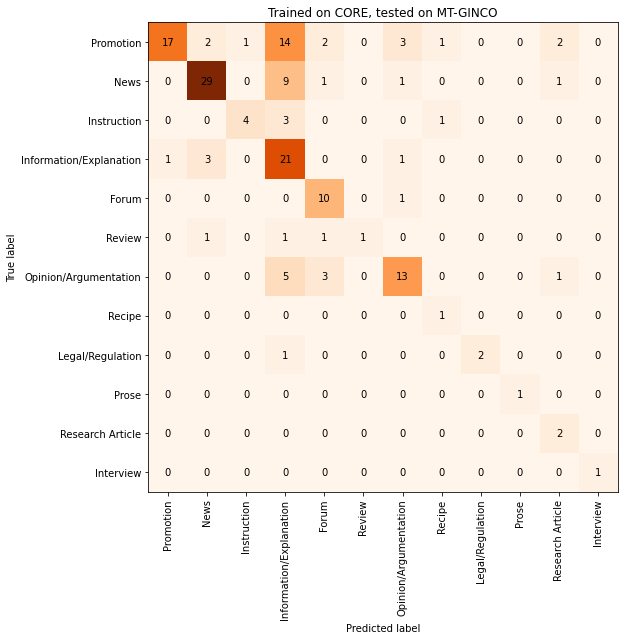

<Figure size 432x288 with 0 Axes>

In [17]:
# Train on CORE, test on MT-GINCO
testing(train_on_CORE,"CORE", MT_GI_test_df, "MT-GINCO")

In [18]:
len(previous_results)

7

In [14]:
# Save the file with updated results.
with open("main-classification-results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")